### Data Preparation & Filtering

In [53]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from math import sqrt
import xgboost as xgb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#### Load the Data

In [54]:
# Load main dataset
train_df = pd.read_csv('data/train_processed.csv')
train_df['date'] = pd.to_datetime(train_df['date'])

In [55]:
train_df.head()

,Unnamed: 0,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,NaN
1,1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,NaN
2,2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,NaN
3,3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,NaN
4,4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,NaN


In [4]:
train_df.isnull().sum()

Unnamed: 0                  0
store_nbr                   0
item_nbr                    0
date                        0
id                   20323588
unit_sales                  0
onpromotion          20323588
year                        0
month                       0
day                         0
day_of_week                 0
unit_sales_7d_avg      124728
dtype: int64

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35069356 entries, 0 to 35069355
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   store_nbr          int64         
 2   item_nbr           int64         
 3   date               datetime64[ns]
 4   id                 float64       
 5   unit_sales         float64       
 6   onpromotion        object        
 7   year               int64         
 8   month              int64         
 9   day                int64         
 10  day_of_week        int64         
 11  unit_sales_7d_avg  float64       
dtypes: datetime64[ns](1), float64(3), int64(7), object(1)
memory usage: 3.1+ GB


#### Filter with Date

In [56]:
max_date = '2014-04-01'
train_df = train_df[(train_df['date'] < max_date)]

In [7]:
train_df.isnull().sum()

Unnamed: 0                 0
store_nbr                  0
item_nbr                   0
date                       0
id                   6690477
unit_sales                 0
onpromotion          6690477
year                       0
month                      0
day                        0
day_of_week                0
unit_sales_7d_avg     124728
dtype: int64

In [8]:
train_df.shape

(9437752, 12)

In [57]:
# Change the data type of 'onpromotion' column to boolean
# and fill NaN values with False
train_df['onpromotion'] = train_df['onpromotion'].fillna(False).astype(bool)
train_df['onpromotion'] = train_df['onpromotion'].astype('int64')


#### Merging External Datasets

In [58]:
# Load and merge store info
stores = pd.read_csv("data/stores.csv")
train_df = train_df.merge(stores, on="store_nbr", how="left")


In [59]:
# Load and merge item info
items = pd.read_csv("data/items.csv")
train_df = train_df.merge(items, on="item_nbr", how="left")

In [60]:
# Merge oil prices
oil = pd.read_csv("data/oil.csv")
oil['date'] = pd.to_datetime(oil['date'])
oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
oil['oil_price'].fillna(method='ffill', inplace=True)
train_df = train_df.merge(oil, on='date', how='left')

In [61]:
# Merge transactions
trans = pd.read_csv("data/transactions.csv")
trans['date'] = pd.to_datetime(trans['date'])
train_df = train_df.merge(trans, on=['date', 'store_nbr'], how='left')
train_df['transactions'].fillna(0, inplace=True)


In [62]:
# Load and prepare holidays
holidays = pd.read_csv("data/holidays_events.csv")
holidays['date'] = pd.to_datetime(holidays['date'])

# Add 'is_holiday' flag BEFORE merging
holidays['is_holiday'] = 1

# Keep only relevant columns
holidays = holidays[['date', 'type', 'locale', 'is_holiday']]

# Merge into main dataset
train_df = train_df.merge(holidays, on='date', how='left')

# Fill non-holiday dates with 0
train_df['is_holiday'] = train_df['is_holiday'].fillna(0).astype(int)


In [63]:
train_df.head()

,Unnamed: 0,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,...,type_x,cluster,family,class,perishable,oil_price,transactions,type_y,locale,is_holiday
0,0,24,105574,2013-01-02,18790.0,12.0,0,2013,1,2,...,D,1,GROCERY I,1045,0,93.14,2605.0,NaN,NaN,0
1,1,24,105574,2013-01-03,59692.0,1.0,0,2013,1,3,...,D,1,GROCERY I,1045,0,92.97,2462.0,NaN,NaN,0
2,2,24,105574,2013-01-04,99664.0,3.0,0,2013,1,4,...,D,1,GROCERY I,1045,0,93.12,2607.0,NaN,NaN,0
3,3,24,105574,2013-01-05,140805.0,4.0,0,2013,1,5,...,D,1,GROCERY I,1045,0,NaN,2578.0,Work Day,National,1
4,4,24,105574,2013-01-06,182800.0,7.0,0,2013,1,6,...,D,1,GROCERY I,1045,0,NaN,2061.0,NaN,NaN,0


In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9541692 entries, 0 to 9541691
Data columns (total 24 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   store_nbr          int64         
 2   item_nbr           int64         
 3   date               datetime64[ns]
 4   id                 float64       
 5   unit_sales         float64       
 6   onpromotion        int64         
 7   year               int64         
 8   month              int64         
 9   day                int64         
 10  day_of_week        int64         
 11  unit_sales_7d_avg  float64       
 12  city               object        
 13  state              object        
 14  type_x             object        
 15  cluster            int64         
 16  family             object        
 17  class              int64         
 18  perishable         int64         
 19  oil_price          float64       
 20  transactions       float

In [65]:
# drop column 'type_x', 'cluster'
train_df = train_df.drop(columns=['type_x', 'cluster'])
# Drop 'id' 
train_df.drop(columns=['id'], inplace=True)
# drop column Unnamed 
train_df = train_df.drop(columns=['Unnamed: 0'])
# drop column class
train_df = train_df.drop(columns=['class'])
# drop 'state' column
train_df = train_df.drop(columns=['state', 'family'])
# drop 'locale', 'type_y' columns
train_df = train_df.drop(columns=['locale', 'type_y'])



In [18]:
train_df.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,city,perishable,oil_price,transactions,is_holiday
0,24,105574,2013-01-02,12.0,0,2013,1,2,2,NaN,Guayaquil,0,93.14,2605.0,0
1,24,105574,2013-01-03,1.0,0,2013,1,3,3,NaN,Guayaquil,0,92.97,2462.0,0
2,24,105574,2013-01-04,3.0,0,2013,1,4,4,NaN,Guayaquil,0,93.12,2607.0,0
3,24,105574,2013-01-05,4.0,0,2013,1,5,5,NaN,Guayaquil,0,NaN,2578.0,1
4,24,105574,2013-01-06,7.0,0,2013,1,6,6,NaN,Guayaquil,0,NaN,2061.0,0


In [19]:
train_df.isnull().sum()

store_nbr                  0
item_nbr                   0
date                       0
unit_sales                 0
onpromotion                0
year                       0
month                      0
day                        0
day_of_week                0
unit_sales_7d_avg     124728
city                       0
perishable                 0
oil_price            2744016
transactions               0
is_holiday                 0
dtype: int64

In [66]:
# fill missing values
train_df['unit_sales_7d_avg'].fillna(method='ffill', inplace=True)
train_df['unit_sales_7d_avg'].fillna(method='bfill', inplace=True)

In [67]:
# fill missing values
train_df['oil_price'].fillna(method='ffill', inplace=True)

In [22]:
train_df.isnull().sum()

store_nbr            0
item_nbr             0
date                 0
unit_sales           0
onpromotion          0
year                 0
month                0
day                  0
day_of_week          0
unit_sales_7d_avg    0
city                 0
perishable           0
oil_price            0
transactions         0
is_holiday           0
dtype: int64

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9541692 entries, 0 to 9541691
Data columns (total 15 columns):
 #   Column             Dtype         
---  ------             -----         
 0   store_nbr          int64         
 1   item_nbr           int64         
 2   date               datetime64[ns]
 3   unit_sales         float64       
 4   onpromotion        int64         
 5   year               int64         
 6   month              int64         
 7   day                int64         
 8   day_of_week        int64         
 9   unit_sales_7d_avg  float64       
 10  city               object        
 11  perishable         int64         
 12  oil_price          float64       
 13  transactions       float64       
 14  is_holiday         int64         
dtypes: datetime64[ns](1), float64(4), int64(9), object(1)
memory usage: 1.1+ GB


### Feature Engineering

In [68]:
# Ensure date is datetime & sorted
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.sort_values(by=['store_nbr', 'item_nbr', 'date'], inplace=True)

In [69]:
# Date Features
train_df['week'] = train_df['date'].dt.isocalendar().week
train_df['is_weekend'] = train_df['day_of_week'].isin([5, 6]).astype(int)
holidays['is_weekday'] = holidays['date'].dt.dayofweek < 5


In [70]:
group = train_df.groupby(['store_nbr', 'item_nbr'])
train_df['lag_1'] = group['unit_sales'].shift(1)
train_df['lag_7'] = group['unit_sales'].shift(7)
train_df['lag_30'] = group['unit_sales'].shift(30)
train_df['rolling_mean_7'] = group['unit_sales'].shift(1).rolling(7).mean()
train_df['rolling_std_7'] = group['unit_sales'].shift(1).rolling(7).std()
train_df = train_df.dropna(subset=['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7'])

In [71]:
train_df.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,...,oil_price,transactions,is_holiday,week,is_weekend,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7
3107437,24,96995,2013-01-09,2.0,0,2013,1,9,2,0.285714,...,93.08,2354.0,0,2,0,0.0,0.0,NaN,0.000000,0.000000
3107438,24,96995,2013-01-10,0.0,0,2013,1,10,3,0.285714,...,93.81,2226.0,0,2,0,2.0,0.0,NaN,0.285714,0.755929
3107439,24,96995,2013-01-11,0.0,0,2013,1,11,4,0.285714,...,93.60,2350.0,0,2,0,0.0,0.0,NaN,0.285714,0.755929
3107440,24,96995,2013-01-12,2.0,0,2013,1,12,5,0.571429,...,93.60,2346.0,1,2,1,0.0,0.0,NaN,0.285714,0.755929
3107441,24,96995,2013-01-13,0.0,0,2013,1,13,6,0.571429,...,93.60,2001.0,0,2,1,2.0,0.0,NaN,0.571429,0.975900


In [72]:
# fill missing values
train_df['lag_30'].fillna(method='ffill', inplace=True)
train_df['lag_30'].fillna(method='bfill', inplace=True)

In [73]:
train_df.isnull().sum()

store_nbr            0
item_nbr             0
date                 0
unit_sales           0
onpromotion          0
year                 0
month                0
day                  0
day_of_week          0
unit_sales_7d_avg    0
city                 0
perishable           0
oil_price            0
transactions         0
is_holiday           0
week                 0
is_weekend           0
lag_1                0
lag_7                0
lag_30               0
rolling_mean_7       0
rolling_std_7        0
dtype: int64

In [74]:
# drop index column
train_df.reset_index(drop=True, inplace=True)

In [75]:
train_df.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,...,oil_price,transactions,is_holiday,week,is_weekend,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7
0,24,96995,2013-01-09,2.0,0,2013,1,9,2,0.285714,...,93.08,2354.0,0,2,0,0.0,0.0,0.0,0.000000,0.000000
1,24,96995,2013-01-10,0.0,0,2013,1,10,3,0.285714,...,93.81,2226.0,0,2,0,2.0,0.0,0.0,0.285714,0.755929
2,24,96995,2013-01-11,0.0,0,2013,1,11,4,0.285714,...,93.60,2350.0,0,2,0,0.0,0.0,0.0,0.285714,0.755929
3,24,96995,2013-01-12,2.0,0,2013,1,12,5,0.571429,...,93.60,2346.0,1,2,1,0.0,0.0,0.0,0.285714,0.755929
4,24,96995,2013-01-13,0.0,0,2013,1,13,6,0.571429,...,93.60,2001.0,0,2,1,2.0,0.0,0.0,0.571429,0.975900


In [76]:
train_df.shape

(9396176, 22)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9396176 entries, 0 to 9396175
Data columns (total 22 columns):
 #   Column             Dtype         
---  ------             -----         
 0   store_nbr          int64         
 1   item_nbr           int64         
 2   date               datetime64[ns]
 3   unit_sales         float64       
 4   onpromotion        int64         
 5   year               int64         
 6   month              int64         
 7   day                int64         
 8   day_of_week        int64         
 9   unit_sales_7d_avg  float64       
 10  city               object        
 11  perishable         int64         
 12  oil_price          float64       
 13  transactions       float64       
 14  is_holiday         int64         
 15  week               UInt32        
 16  is_weekend         int64         
 17  lag_1              float64       
 18  lag_7              float64       
 19  lag_30             float64       
 20  rolling_mean_7     float

In [77]:
# export to csv
train_df.to_csv('data/train_final.csv', index=False)

### EDA

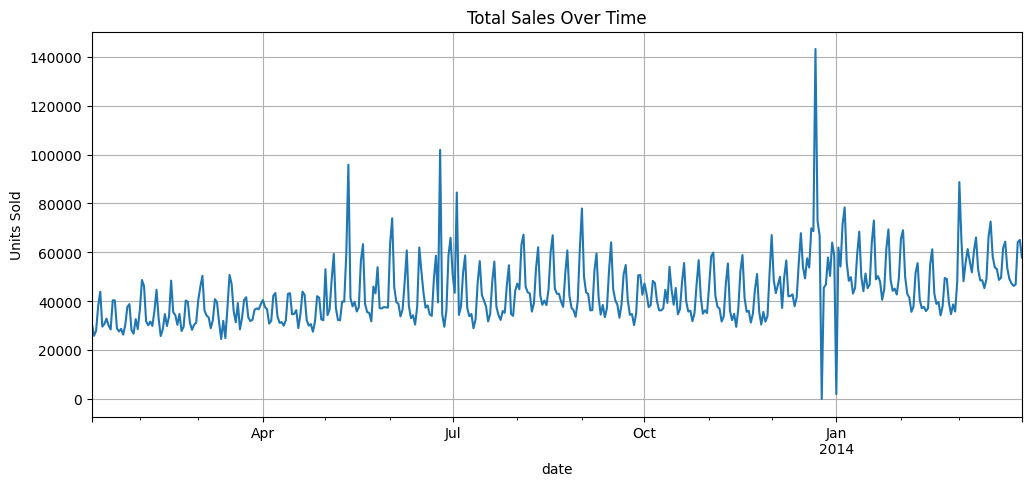

In [35]:
# Sales Over Time
train_df.groupby('date')['unit_sales'].sum().plot(figsize=(12, 5), title='Total Sales Over Time')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()


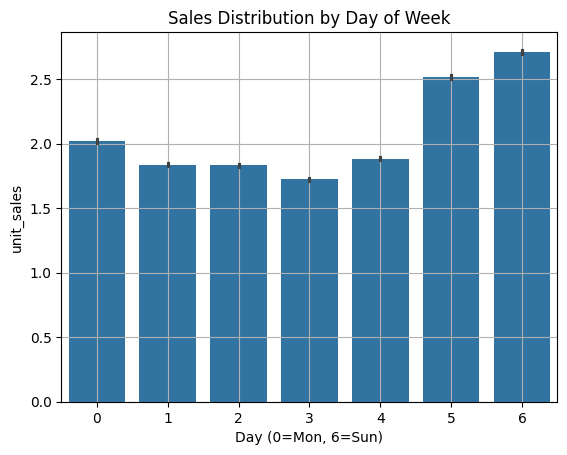

In [36]:
# Sales by Day of Week
sns.barplot(x='day_of_week', y='unit_sales', data=train_df)
plt.title('Sales Distribution by Day of Week')
plt.xlabel('Day (0=Mon, 6=Sun)')
plt.grid(True)
plt.show()


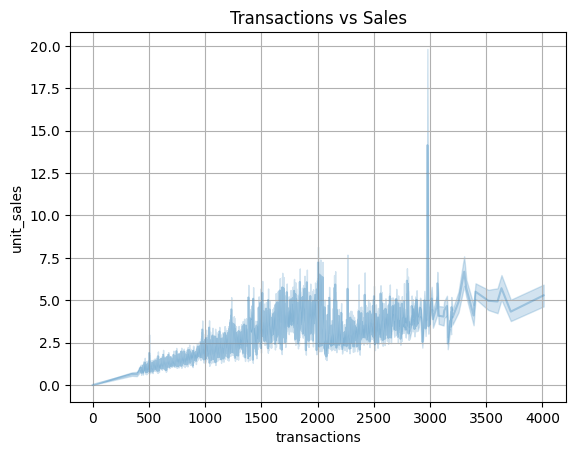

In [ ]:
# Sales vs. Transactions
sns.lineplot(x='transactions', y='unit_sales', data=train_df, alpha=0.3)
plt.title('Transactions vs Sales')
plt.grid(True)
plt.show()

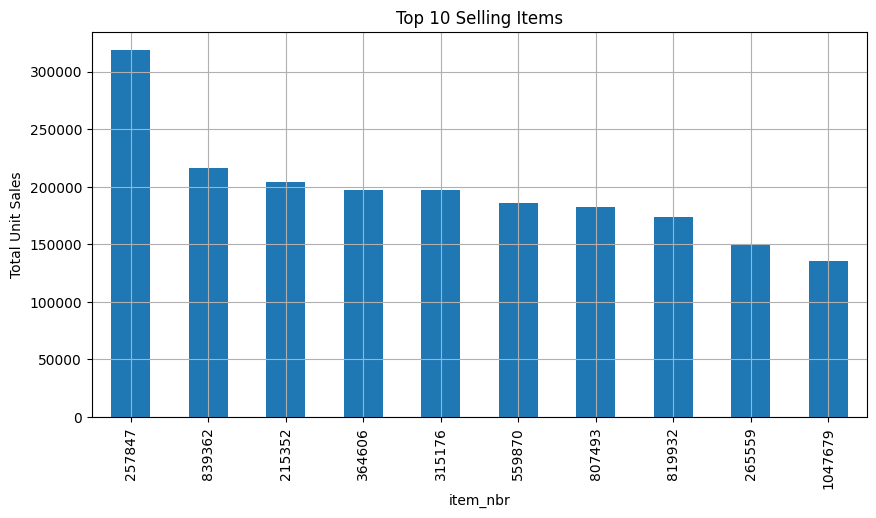

In [ ]:
# Top 10 Most Sold Items
top_items = train_df.groupby('item_nbr')['unit_sales'].sum().sort_values(ascending=False).head(10)
top_items.plot(kind='bar', title='Top 10 Selling Items', figsize=(10, 5))
plt.ylabel('Total Unit Sales')
plt.grid(True)
plt.show()

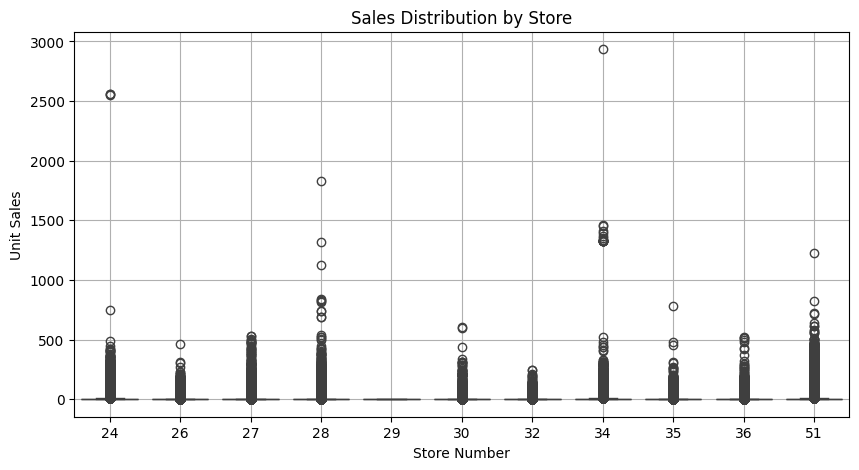

In [37]:
# Sales Distribution Across Stores
plt.figure(figsize=(10, 5))
sns.boxplot(x='store_nbr', y='unit_sales', data=train_df)
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Unit Sales')
plt.grid(True)
plt.show()

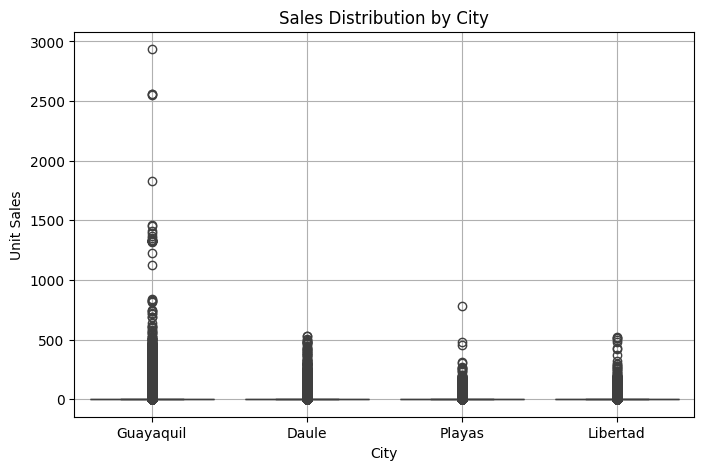

In [ ]:
# sales over city
plt.figure(figsize=(8, 5))
sns.boxplot(x='city', y='unit_sales', data=train_df)
plt.title('Sales Distribution by City')
plt.xlabel('City')                                                              
plt.ylabel('Unit Sales')
plt.grid(True)
plt.show()

In [78]:
# drop city column
train_df = train_df.drop(columns=['city'])

### Time-Based Train/Test Split

In [79]:
# Make sure 'date' is datetime
train_df['date'] = pd.to_datetime(train_df['date'])
split_date = '2014-01-01'
train = train_df[train_df['date'] < split_date]
test = train_df[train_df['date'] > split_date]

### Feature & Target Separation

In [80]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']


#### NAIVE model for Time Series( One-Step Forecast)

In [47]:
# Naive forecast: predict the last observed value
# Assumes your data is sorted by date
y_pred_naive = y_test.shift(1)  # Predict previous day's sales

# Handle first NaN value (can drop it or fill)
y_pred_naive = y_pred_naive.fillna(method='bfill')  # or .dropna()

# Calculate MSE
mse_naive = mean_squared_error(y_test, y_pred_naive)

# Calculate RMSE manually
rmse_naive = np.sqrt(mse_naive)

print(f"Naive Model RMSE: {rmse_naive:.4f}")

# Calculate r2
r2_naive = r2_score(y_test, y_pred_naive)
print(f"Naive Model R2: {r2_naive:.4f}")

Naive Model RMSE: 6.2801
Naive Model R2: 0.4820


##### The Naive model gives an RMSE of 6.28, which sets a baseline for performance. While it is simple and interpretable, it does not capture any patterns or relationships in the data. Therefore, we proceed to train more sophisticated models like XGBoost to potentially improve prediction accuracy. If XGBoost achieves a lower RMSE, it will demonstrate added predictive value over this naive approach.

##### Plot Naive Predictions vs. Actual

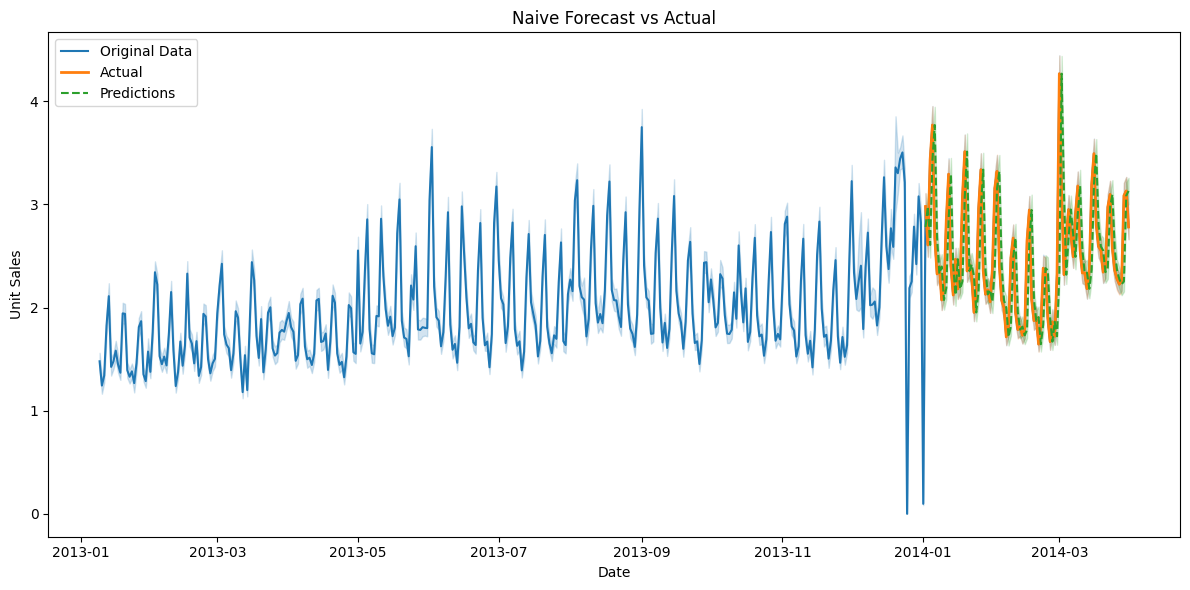

In [48]:
# Create a plot
plt.figure(figsize=(12, 6))

# Plot the original data
sns.lineplot(x=train_df['date'], y=train_df['unit_sales'], label='Original Data')

# Plot the predictions vs actual values
sns.lineplot(x=test['date'], y=y_test, label='Actual', linewidth=2)
sns.lineplot(x=test['date'], y=y_pred_naive, label='Predictions', linestyle='--')

# Add titles and labels
plt.title('Naive Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.tight_layout()
plt.show()

##### we can see another baseline model

#### XGBoost Model

In [49]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

##### test the model

In [50]:
# Predict on test set
y_pred = xgboost_model.predict(X_test)


##### Evaluate the model

In [51]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.8547882339767793
MAE: 0.8015753926840683


##### We can plot the differences between predicted and actual values

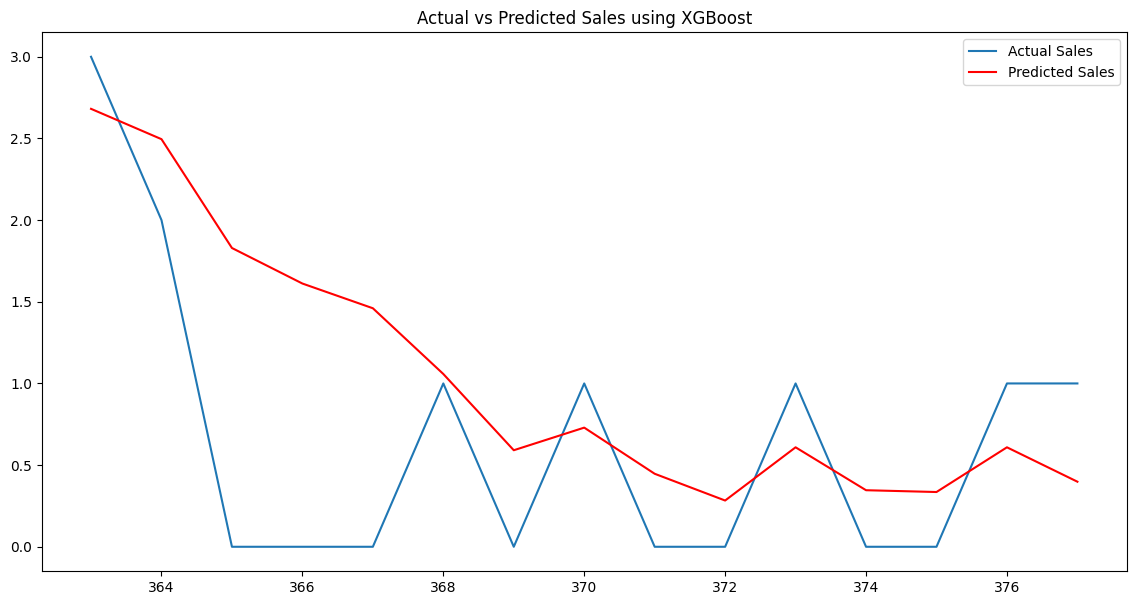

In [52]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()